# Multi-Agent Systems with Middleware

## Overview
Learn how to build **collaborative multi-agent systems** where specialized agents work together, coordinated by middleware for safety, efficiency, and observability.

## What You'll Build
1. **Specialized agents**: Research, writing, and review agents
2. **Orchestration patterns**: Sequential, parallel, and conditional routing
3. **Agent-specific middleware**: Custom controls for each agent
4. **Global middleware**: System-wide guardrails and monitoring
5. **Communication protocols**: How agents share state and results

## Why Multi-Agent?
**Single Agent Limitations:**
- 🤔 Jack-of-all-trades, master of none
- 📚 Context overload with too many tools
- 🔄 Complex branching logic

**Multi-Agent Benefits:**
- ✅ **Specialization**: Each agent excels at one task
- ✅ **Modularity**: Easy to update individual agents
- ✅ **Scalability**: Add new agents without affecting others
- ✅ **Clarity**: Explicit workflow vs. implicit agent decisions

## Architecture
```
┌─────────────────────────────────────────┐
│     Global Middleware Layer             │
│  (Security, Logging, Performance)       │
└─────────────────────────────────────────┘
           ↓           ↓           ↓
    ┌──────────┐ ┌──────────┐ ┌──────────┐
    │ Research │ │ Writing  │ │ Review   │
    │  Agent   │ │  Agent   │ │  Agent   │
    └──────────┘ └──────────┘ └──────────┘
         ↓            ↓            ↓
    ┌──────────┐ ┌──────────┐ ┌──────────┐
    │Agent MW  │ │Agent MW  │ │Agent MW  │
    │(Limits)  │ │(Quality) │ │(Checks)  │
    └──────────┘ └──────────┘ └──────────┘
```

## Setup:  Import

In [1]:
import os
import logging
from typing import Any, Annotated, TypedDict, Literal
import operator
from dotenv import load_dotenv

# LangChain and LangGraph
from langchain.agents import create_agent
from langchain.agents.middleware import (
    ModelCallLimitMiddleware,
    ToolCallLimitMiddleware,
    AgentMiddleware,
    AgentState,
    before_model,
    after_model,
)
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.tools import tool
from langchain.messages import HumanMessage, AIMessage, SystemMessage

# LangGraph for orchestration
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

# Load environment
load_dotenv()

print("✓ All imports successful")
print("✓ Ready to build multi-agent systems!")

/Users/laurafunderburk/Documents/GitHub/Building-Natural-Language-Pipelines/ch2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ All imports successful
✓ Ready to build multi-agent systems!


## Part 1: Define Shared State

All agents in the system share a common state structure.

In [2]:
class MultiAgentState(TypedDict):
    """Shared state across all agents in the system."""
    
    # Input/Output
    topic: str  # The research topic
    final_report: str  # The final output
    
    # Intermediate results
    research_findings: str  # From research agent
    draft_content: str  # From writing agent
    review_feedback: str  # From review agent
    
    # Workflow control
    current_agent: str  # Which agent is active
    iteration: int  # For revision loops
    quality_score: float  # Review agent's assessment
    
    # Messages for agent communication
    messages: Annotated[list, operator.add]  # Accumulated messages

print("✓ MultiAgentState defined")
print("\nState fields:")
print("  - topic: Research topic")
print("  - research_findings: Research agent output")
print("  - draft_content: Writing agent output")
print("  - review_feedback: Review agent output")
print("  - quality_score: Quality assessment (0-10)")
print("  - iteration: Revision counter")

✓ MultiAgentState defined

State fields:
  - topic: Research topic
  - research_findings: Research agent output
  - draft_content: Writing agent output
  - review_feedback: Review agent output
  - quality_score: Quality assessment (0-10)
  - iteration: Revision counter


## Part 2: Create Specialized Tools

In [3]:
# Tool for research agent
search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True
)

# Tool for writing agent
@tool
def check_word_count(text: str) -> str:
    """Count words in the provided text."""
    count = len(text.split())
    return f"Word count: {count}"

@tool
def check_readability(text: str) -> str:
    """Assess text readability (simplified)."""
    sentences = text.count('.') + text.count('!') + text.count('?')
    words = len(text.split())
    avg_sentence_length = words / max(sentences, 1)
    
    if avg_sentence_length < 15:
        level = "Easy to read"
    elif avg_sentence_length < 25:
        level = "Moderate"
    else:
        level = "Complex"
    
    return f"Readability: {level} (avg {avg_sentence_length:.1f} words/sentence)"

# Tool for review agent
@tool
def calculate_quality_score(text: str, criteria: str) -> str:
    """Calculate a quality score based on criteria (simplified heuristic)."""
    score = 5.0  # Base score
    
    # Length check
    words = len(text.split())
    if words > 200:
        score += 2.0
    elif words > 100:
        score += 1.0
    
    # Structure check (has paragraphs)
    if text.count('\n\n') > 0:
        score += 1.0
    
    # Key criteria mentions
    if criteria.lower() in text.lower():
        score += 1.0
    
    return f"Quality score: {min(score, 10.0)}/10"

print("✓ Tools created:")
print("  - Research: TavilySearchResults")
print("  - Writing: check_word_count, check_readability")
print("  - Review: calculate_quality_score")

✓ Tools created:
  - Research: TavilySearchResults
  - Writing: check_word_count, check_readability
  - Review: calculate_quality_score


/var/folders/k7/8m84jpf52x7gvx628v82h2p80000gn/T/ipykernel_14400/611055139.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(


## Part 3: Define Agent-Specific Middleware

In [4]:
# Research Agent Middleware - Limit search calls
class ResearchMonitorMiddleware(AgentMiddleware):
    """Monitor and limit research agent's search usage."""
    
    def __init__(self):
        super().__init__()
        self.search_count = 0
    
    def wrap_tool_call(self, request, handler):
        tool_name = request.tool_call['name']
        
        if 'search' in tool_name.lower():
            self.search_count += 1
            logger.info(f"🔍 Research search #{self.search_count}")
        
        return handler(request)

# Writing Agent Middleware - Ensure quality checks
@after_model
def enforce_writing_standards(state: AgentState, runtime) -> dict[str, Any] | None:
    """Ensure writing meets minimum standards."""
    last_msg = state['messages'][-1]
    
    if hasattr(last_msg, 'content') and last_msg.content:
        content = last_msg.content
        word_count = len(content.split())
        
        if word_count < 50:
            logger.warning(f"⚠️  Writing too short: {word_count} words")
            # Could force revision here
    
    return None

# Review Agent Middleware - Log all assessments
@before_model
def log_review_start(state: AgentState, runtime) -> None:
    """Log when review begins."""
    logger.info("📋 Review agent starting assessment...")

@after_model
def log_review_complete(state: AgentState, runtime) -> None:
    """Log when review completes."""
    logger.info("✅ Review agent completed assessment")

print("✓ Agent-specific middleware defined:")
print("  - Research: Search monitoring")
print("  - Writing: Quality standards enforcement")
print("  - Review: Assessment logging")

✓ Agent-specific middleware defined:
  - Research: Search monitoring
  - Writing: Quality standards enforcement
  - Review: Assessment logging


## Part 4: Define Global Middleware

These apply to all agents in the system.

In [5]:
import time

class GlobalPerformanceMiddleware(AgentMiddleware):
    """Track performance across all agents."""
    
    def __init__(self):
        super().__init__()
        self.agent_times = {}
    
    def wrap_model_call(self, request, handler):
        start = time.time()
        result = handler(request)
        duration = time.time() - start
        
        # Track by agent (would need agent context in production)
        logger.info(f"⏱️  Model call: {duration:.2f}s")
        
        return result
    
    def get_report(self):
        return self.agent_times

@before_model
def global_input_validation(state: AgentState, runtime) -> dict[str, Any] | None:
    """Validate inputs across all agents."""
    # Check for empty or invalid inputs
    if state['messages'] and len(state['messages']) > 100:
        logger.warning("⚠️  Message history getting long")
    
    return None

print("✓ Global middleware defined:")
print("  - Performance tracking")
print("  - Input validation")

✓ Global middleware defined:
  - Performance tracking
  - Input validation


## Part 5: Create Individual Agents

In [6]:
# Initialize global middleware instances
global_perf = GlobalPerformanceMiddleware()
research_monitor = ResearchMonitorMiddleware()

# 1. Research Agent
research_agent = create_agent(
    model="gpt-4o-mini",
    tools=[search_tool],
    middleware=[
        global_input_validation,
        global_perf,
        research_monitor,
        ToolCallLimitMiddleware(tool_name="tavily_search_results_json", run_limit=3)
    ],
    system_prompt="""
You are a RESEARCH AGENT. Your job is to gather comprehensive, factual information.

Guidelines:
- Use the search tool to find current, accurate information
- Focus on facts, statistics, and credible sources
- Organize findings clearly
- Keep research concise but thorough
- Return ONLY the research findings, no meta-commentary
"""
)

# 2. Writing Agent
writing_agent = create_agent(
    model="gpt-4o-mini",
    tools=[check_word_count, check_readability],
    middleware=[
        global_input_validation,
        global_perf,
        enforce_writing_standards,
        ModelCallLimitMiddleware(run_limit=3, exit_behavior="end")
    ],
    system_prompt="""
You are a WRITING AGENT. Your job is to create clear, engaging content.

Guidelines:
- Transform research into well-structured prose
- Use clear paragraphs and transitions
- Aim for 200-400 words
- Make it readable and engaging
- Return ONLY the written content, no meta-commentary
"""
)

# 3. Review Agent
review_agent = create_agent(
    model="gpt-4o-mini",
    tools=[calculate_quality_score],
    middleware=[
        global_input_validation,
        global_perf,
        log_review_start,
        log_review_complete,
        ModelCallLimitMiddleware(run_limit=2, exit_behavior="end")
    ],
    system_prompt="""
You are a REVIEW AGENT. Your job is to assess content quality.

Guidelines:
- Evaluate clarity, accuracy, and completeness
- Provide a quality score (1-10)
- If score < 7, provide specific improvement suggestions
- If score >= 7, approve the content
- Return format: "SCORE: X/10\nFEEDBACK: [your assessment]"
"""
)

print("✓ Three specialized agents created:")
print("  1. Research Agent (with search tools)")
print("  2. Writing Agent (with readability tools)")
print("  3. Review Agent (with quality assessment)")

✓ Three specialized agents created:
  1. Research Agent (with search tools)
  2. Writing Agent (with readability tools)
  3. Review Agent (with quality assessment)


## Part 6: Create Agent Wrapper Nodes

Wrap each agent to integrate with LangGraph's state management.

In [7]:
def research_node(state: MultiAgentState) -> MultiAgentState:
    """Research agent node."""
    logger.info("\n" + "="*80)
    logger.info("🔍 RESEARCH AGENT ACTIVE")
    logger.info("="*80)
    
    # Prepare input
    topic = state["topic"]
    messages = [{"role": "user", "content": f"Research this topic thoroughly: {topic}"}]
    
    # Invoke agent
    result = research_agent.invoke({"messages": messages})
    
    # Extract findings
    findings = result["messages"][-1].content
    
    return {
        "research_findings": findings,
        "current_agent": "research",
        "messages": [AIMessage(content=f"Research completed on: {topic}")]
    }

def writing_node(state: MultiAgentState) -> MultiAgentState:
    """Writing agent node."""
    logger.info("\n" + "="*80)
    logger.info("✍️  WRITING AGENT ACTIVE")
    logger.info("="*80)
    
    # Prepare input with research findings
    research = state.get("research_findings", "No research available")
    feedback = state.get("review_feedback", "")
    
    if feedback:
        prompt = f"""Revise the following draft based on this feedback:

FEEDBACK: {feedback}

DRAFT: {state.get('draft_content', '')}

RESEARCH: {research}
"""
    else:
        prompt = f"Write a comprehensive article based on this research:\n\n{research}"
    
    messages = [{"role": "user", "content": prompt}]
    
    # Invoke agent
    result = writing_agent.invoke({"messages": messages})
    
    # Extract draft
    draft = result["messages"][-1].content
    
    return {
        "draft_content": draft,
        "current_agent": "writing",
        "messages": [AIMessage(content="Draft completed")]
    }

def review_node(state: MultiAgentState) -> MultiAgentState:
    """Review agent node."""
    logger.info("\n" + "="*80)
    logger.info("📋 REVIEW AGENT ACTIVE")
    logger.info("="*80)
    
    # Prepare input
    draft = state.get("draft_content", "No draft available")
    topic = state["topic"]
    
    prompt = f"""Review this content for quality:

TOPIC: {topic}

CONTENT:
{draft}

Provide a score and feedback.
"""
    
    messages = [{"role": "user", "content": prompt}]
    
    # Invoke agent
    result = review_agent.invoke({"messages": messages})
    
    # Extract review
    review = result["messages"][-1].content
    
    # Parse score (simple extraction)
    import re
    score_match = re.search(r'SCORE[:\s]+(\d+)', review)
    score = float(score_match.group(1)) if score_match else 5.0
    
    return {
        "review_feedback": review,
        "quality_score": score,
        "current_agent": "review",
        "iteration": state.get("iteration", 0) + 1,
        "messages": [AIMessage(content=f"Review completed (Score: {score}/10)")]
    }

def finalize_node(state: MultiAgentState) -> MultiAgentState:
    """Finalize and return the approved content."""
    logger.info("\n" + "="*80)
    logger.info("✅ FINALIZING REPORT")
    logger.info("="*80)
    
    return {
        "final_report": state["draft_content"],
        "current_agent": "finalize",
        "messages": [AIMessage(content="Report finalized and approved")]
    }

print("✓ Agent wrapper nodes created:")
print("  - research_node()")
print("  - writing_node()")
print("  - review_node()")
print("  - finalize_node()")

✓ Agent wrapper nodes created:
  - research_node()
  - writing_node()
  - review_node()
  - finalize_node()


## Part 7: Build the Multi-Agent Workflow

Use LangGraph to orchestrate the agents.

In [8]:
# Define routing logic
def should_revise(state: MultiAgentState) -> Literal["revise", "finalize"]:
    """Decide whether content needs revision."""
    score = state.get("quality_score", 0)
    iteration = state.get("iteration", 0)
    
    # Max 2 revisions
    if score >= 7.0 or iteration >= 2:
        logger.info(f"✅ Content approved (Score: {score}/10, Iteration: {iteration})")
        return "finalize"
    else:
        logger.info(f"🔄 Revision needed (Score: {score}/10, Iteration: {iteration})")
        return "revise"

# Build the graph
workflow = StateGraph(MultiAgentState)

# Add nodes
workflow.add_node("research", research_node)
workflow.add_node("writing", writing_node)
workflow.add_node("review", review_node)
workflow.add_node("finalize", finalize_node)

# Define edges
workflow.set_entry_point("research")
workflow.add_edge("research", "writing")
workflow.add_edge("writing", "review")
workflow.add_conditional_edges(
    "review",
    should_revise,
    {
        "revise": "writing",  # Go back to writing
        "finalize": "finalize"  # Move to finalize
    }
)
workflow.add_edge("finalize", END)

# Compile
multi_agent_system = workflow.compile()

## Part 8: Visualize the System

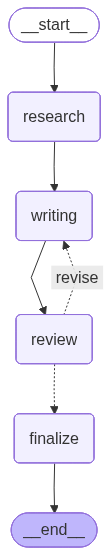

✓ Workflow visualization displayed above


In [9]:
# Display the workflow graph
try:
    from IPython.display import Image, display
    display(Image(multi_agent_system.get_graph().draw_mermaid_png()))
    print("✓ Workflow visualization displayed above")
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nWorkflow structure:")
    print(multi_agent_system.get_graph().draw_ascii())

## Part 9: Run the Multi-Agent System

In [10]:
# Define the research topic
topic = "The impact of artificial intelligence on healthcare"

# Initialize state
initial_state = {
    "topic": topic,
    "research_findings": "",
    "draft_content": "",
    "review_feedback": "",
    "final_report": "",
    "current_agent": "",
    "iteration": 0,
    "quality_score": 0.0,
    "messages": []
}

print("\n" + "#" * 80)
print("# MULTI-AGENT SYSTEM EXECUTION")
print("#" * 80)
print(f"\nTopic: {topic}\n")

# Execute the workflow
final_state = multi_agent_system.invoke(initial_state)

print("\n" + "#" * 80)
print("# EXECUTION COMPLETE")
print("#" * 80)

INFO: 
INFO: 🔍 RESEARCH AGENT ACTIVE
INFO: ================================================================================



################################################################################
# MULTI-AGENT SYSTEM EXECUTION
################################################################################

Topic: The impact of artificial intelligence on healthcare



INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: ⏱️  Model call: 1.27s
INFO: 🔍 Research search #1
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: ⏱️  Model call: 11.12s
INFO: 
INFO: ✍️  WRITING AGENT ACTIVE
INFO: ================================================================================
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: ⏱️  Model call: 9.84s
INFO: 
INFO: 📋 REVIEW AGENT ACTIVE
INFO: ================================================================================
INFO: 📋 Review agent starting assessment...
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: ⏱️  Model call: 8.64s
INFO: ✅ Review agent completed assessment
INFO: 📋 Review agent starting assessment...
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: ⏱️  Model call: 2.18s
INFO: ✅ Review agent comp


################################################################################
# EXECUTION COMPLETE
################################################################################


## Part 10: View Results

In [18]:
# Display the final report
print("\n" + "="*80)
print("FINAL REPORT")
print("="*80 + "\n")
print(final_state["final_report"])
print("\n" + "="*80)


FINAL REPORT

Artificial intelligence (AI) is ushering in a new era in the healthcare sector, one that promises enhanced accuracy in diagnosis, personalized treatment plans, and improved patient engagement. This technological transformation is reshaping clinical workflows and has the ability to address persistent challenges within healthcare systems. As of 2023, the integration of AI tools is becoming increasingly prevalent among healthcare professionals.

A notable trend is the rapid increase in the adoption rates of AI in healthcare. A survey conducted in 2025 reported that 66% of physicians are utilizing health-AI tools, a significant leap from 38% just two years earlier. Furthermore, a majority of healthcare providers—68%—expressed confidence in the positive impact of AI on patient care. The ongoing embrace of AI can be attributed to several key use cases that are making substantial differences in healthcare delivery.

Firstly, Natural Language Processing (NLP) is a groundbreaking

In [12]:
# Display workflow statistics
print("\n" + "="*80)
print("WORKFLOW STATISTICS")
print("="*80)
print(f"Topic: {final_state['topic']}")
print(f"Iterations: {final_state['iteration']}")
print(f"Final Quality Score: {final_state['quality_score']}/10")
print(f"Total Agent Steps: {len(final_state['messages'])}")
print(f"\nLast Review Feedback:")
print(final_state['review_feedback'])


WORKFLOW STATISTICS
Topic: The impact of artificial intelligence on healthcare
Iterations: 1
Final Quality Score: 8.0/10
Total Agent Steps: 4

Last Review Feedback:
SCORE: 8/10  
FEEDBACK: The content is well-written, clear, and covers the topic of the impact of artificial intelligence on healthcare comprehensively. It accurately highlights the advantages, applications, and challenges of AI in the healthcare sector. The use of statistics adds credibility. 

To further enhance the content, consider adding more specific examples of AI applications in healthcare, perhaps including recent case studies or advancements from 2023 to provide an updated context. Overall, the content effectively communicates its message and is approved for use.


In [13]:
# Display middleware statistics
print("\n" + "="*80)
print("MIDDLEWARE STATISTICS")
print("="*80)
print(f"\nResearch Agent:")
print(f"  - Search calls: {research_monitor.search_count}")
print(f"\nGlobal Performance:")
print(f"  - Tracked across all agents")
print(f"\n✓ All middleware executed successfully")


MIDDLEWARE STATISTICS

Research Agent:
  - Search calls: 1

Global Performance:
  - Tracked across all agents

✓ All middleware executed successfully


## Part 11: Stream Multi-Agent Execution

Watch the agents work in real-time.

In [14]:
# New topic for streaming demo
streaming_topic = "Benefits of meditation for mental health"

streaming_state = {
    "topic": streaming_topic,
    "research_findings": "",
    "draft_content": "",
    "review_feedback": "",
    "final_report": "",
    "current_agent": "",
    "iteration": 0,
    "quality_score": 0.0,
    "messages": []
}

print("\n" + "#" * 80)
print("# STREAMING MULTI-AGENT EXECUTION")
print("#" * 80)
print(f"\nTopic: {streaming_topic}\n")

# Stream the execution
for step, output in enumerate(multi_agent_system.stream(streaming_state), 1):
    print(f"\n{'─'*80}")
    print(f"Step {step}: {list(output.keys())}")
    print(f"{'─'*80}")
    
    for node_name, node_output in output.items():
        if node_name != "__end__":
            current = node_output.get("current_agent", "unknown")
            print(f"\n🤖 Agent: {current}")
            if "quality_score" in node_output and node_output["quality_score"] > 0:
                print(f"📊 Quality Score: {node_output['quality_score']}/10")

print("\n" + "#" * 80)
print("# STREAMING COMPLETE")
print("#" * 80)

INFO: 
INFO: 🔍 RESEARCH AGENT ACTIVE
INFO: ================================================================================



################################################################################
# STREAMING MULTI-AGENT EXECUTION
################################################################################

Topic: Benefits of meditation for mental health



INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: ⏱️  Model call: 0.84s
INFO: 🔍 Research search #2
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: ⏱️  Model call: 8.07s
INFO: 
INFO: ✍️  WRITING AGENT ACTIVE
INFO: ================================================================================



────────────────────────────────────────────────────────────────────────────────
Step 1: ['research']
────────────────────────────────────────────────────────────────────────────────

🤖 Agent: research


INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: ⏱️  Model call: 8.31s
INFO: 
INFO: 📋 REVIEW AGENT ACTIVE
INFO: ================================================================================
INFO: 📋 Review agent starting assessment...



────────────────────────────────────────────────────────────────────────────────
Step 2: ['writing']
────────────────────────────────────────────────────────────────────────────────

🤖 Agent: writing


INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: ⏱️  Model call: 4.16s
INFO: ✅ Review agent completed assessment
INFO: 📋 Review agent starting assessment...
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: ⏱️  Model call: 2.98s
INFO: ✅ Review agent completed assessment
INFO: ✅ Content approved (Score: 8.0/10, Iteration: 1)
INFO: 
INFO: ✅ FINALIZING REPORT
INFO: ================================================================================



────────────────────────────────────────────────────────────────────────────────
Step 3: ['review']
────────────────────────────────────────────────────────────────────────────────

🤖 Agent: review
📊 Quality Score: 8.0/10

────────────────────────────────────────────────────────────────────────────────
Step 4: ['finalize']
────────────────────────────────────────────────────────────────────────────────

🤖 Agent: finalize

################################################################################
# STREAMING COMPLETE
################################################################################


## Part 12: Advanced Pattern - Parallel Agent Execution

Run multiple agents in parallel for different aspects of a topic.

In [15]:
# Define state for parallel execution
class ParallelAgentState(TypedDict):
    """State for parallel multi-agent execution."""
    topic: str
    
    # Results from parallel agents
    technical_research: str
    market_research: str
    ethical_research: str
    
    # Synthesized output
    comprehensive_report: str
    messages: Annotated[list, operator.add]

# Create specialized research agents
technical_agent = create_agent(
    model="gpt-4o-mini",
    tools=[search_tool],
    middleware=[global_perf],
    system_prompt="You research TECHNICAL aspects. Focus on implementation, technology, and engineering."
)

market_agent = create_agent(
    model="gpt-4o-mini",
    tools=[search_tool],
    middleware=[global_perf],
    system_prompt="You research MARKET aspects. Focus on business, economics, and industry trends."
)

ethical_agent = create_agent(
    model="gpt-4o-mini",
    tools=[search_tool],
    middleware=[global_perf],
    system_prompt="You research ETHICAL aspects. Focus on social impact, privacy, and moral considerations."
)

print("✓ Parallel agents created:")
print("  - Technical Research Agent")
print("  - Market Research Agent")
print("  - Ethical Research Agent")

✓ Parallel agents created:
  - Technical Research Agent
  - Market Research Agent
  - Ethical Research Agent


In [19]:
# Create parallel nodes
def technical_research_node(state: ParallelAgentState) -> ParallelAgentState:
    logger.info("🔧 Technical research starting...")
    result = technical_agent.invoke({
        "messages": [{"role": "user", "content": f"Research technical aspects of: {state['topic']}"}]
    })
    return {"technical_research": result["messages"][-1].content}

def market_research_node(state: ParallelAgentState) -> ParallelAgentState:
    logger.info("💼 Market research starting...")
    result = market_agent.invoke({
        "messages": [{"role": "user", "content": f"Research market aspects of: {state['topic']}"}]
    })
    return {"market_research": result["messages"][-1].content}

def ethical_research_node(state: ParallelAgentState) -> ParallelAgentState:
    logger.info("⚖️  Ethical research starting...")
    result = ethical_agent.invoke({
        "messages": [{"role": "user", "content": f"Research ethical aspects of: {state['topic']}"}]
    })
    return {"ethical_research": result["messages"][-1].content}

def synthesize_node(state: ParallelAgentState) -> ParallelAgentState:
    logger.info("🔀 Synthesizing all research...")
    
    synthesis_prompt = f"""
Synthesize these three research perspectives into a comprehensive report:

TECHNICAL:
{state['technical_research']}

MARKET:
{state['market_research']}

ETHICAL:
{state['ethical_research']}

Create a cohesive, well-structured report.
"""
    
    synthesizer = ChatOpenAI(model="gpt-4o-mini")
    result = synthesizer.invoke(synthesis_prompt)
    
    return {"comprehensive_report": result.content}

# Build parallel workflow
parallel_workflow = StateGraph(ParallelAgentState)

# Add nodes
parallel_workflow.add_node("technical", technical_research_node)
parallel_workflow.add_node("market", market_research_node)
parallel_workflow.add_node("ethical", ethical_research_node)
parallel_workflow.add_node("synthesize", synthesize_node)

# Set up parallel execution
parallel_workflow.set_entry_point("technical")
parallel_workflow.set_entry_point("market")
parallel_workflow.set_entry_point("ethical")

# All converge to synthesis
parallel_workflow.add_edge("technical", "synthesize")
parallel_workflow.add_edge("market", "synthesize")
parallel_workflow.add_edge("ethical", "synthesize")
parallel_workflow.add_edge("synthesize", END)

parallel_system = parallel_workflow.compile()

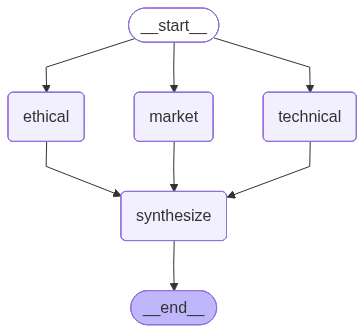

In [20]:
display(Image(parallel_system.get_graph().draw_mermaid_png()))

In [21]:
# Run parallel system
parallel_topic = "Autonomous vehicles in urban transportation"

parallel_state = {
    "topic": parallel_topic,
    "technical_research": "",
    "market_research": "",
    "ethical_research": "",
    "comprehensive_report": "",
    "messages": []
}

print("\n" + "#" * 80)
print("# PARALLEL MULTI-AGENT EXECUTION")
print("#" * 80)
print(f"\nTopic: {parallel_topic}")
print("\n⚡ Running three agents in parallel...\n")

parallel_result = parallel_system.invoke(parallel_state)

print("\n" + "="*80)
print("COMPREHENSIVE REPORT (From Parallel Agents)")
print("="*80 + "\n")
print(parallel_result["comprehensive_report"])
print("\n" + "="*80)

INFO: ⚖️  Ethical research starting...
INFO: 💼 Market research starting...
INFO: 🔧 Technical research starting...



################################################################################
# PARALLEL MULTI-AGENT EXECUTION
################################################################################

Topic: Autonomous vehicles in urban transportation

⚡ Running three agents in parallel...



INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: ⏱️  Model call: 0.80s
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: ⏱️  Model call: 0.93s
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: ⏱️  Model call: 0.95s
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: ⏱️  Model call: 10.06s
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: ⏱️  Model call: 10.12s
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: ⏱️  Model call: 11.16s
INFO: 🔀 Synthesizing all research...
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



COMPREHENSIVE REPORT (From Parallel Agents)

# Comprehensive Report on the Integration of Autonomous Vehicles in Urban Transportation

## Executive Summary

The advent of autonomous vehicles (AVs) stands poised to revolutionize urban transportation systems, presenting significant opportunities and challenges across technical, market, and ethical dimensions. This report synthesizes technical advancements, market trends, and ethical considerations associated with the deployment of AVs in urban settings, offering insights for stakeholders as they navigate the evolving landscape.

## 1. Technical Aspects

### 1.1 Recognition and Response Capabilities
Autonomous vehicles must develop sophisticated recognition capabilities to operate safely in complex urban environments. They must identify traffic signals, dynamic signage, and various road users, including pedestrians and cyclists, under different conditions. Ensuring AVs meet rigorous recognition standards is essential for their safe integ

## Key Takeaways

### Multi-Agent Architecture
✅ **Specialization**: Each agent focuses on one task  
✅ **Middleware integration**: Agent-specific + global layers  
✅ **State management**: Shared state for communication  
✅ **Orchestration**: LangGraph for complex workflows  
✅ **Flexibility**: Sequential, parallel, or conditional routing  

### Middleware Strategies

| Layer | Purpose | Examples |
|-------|---------|----------|
| Global | System-wide controls | Security, performance tracking |
| Agent-specific | Role-based controls | Research limits, writing standards |
| Tool-specific | Resource management | API quotas, cost control |

### Orchestration Patterns

**Sequential**: Research → Write → Review → Finalize
- Best for: Linear workflows with dependencies
- Example: Content creation pipeline

**Parallel**: Multiple agents → Synthesize
- Best for: Independent perspectives
- Example: Multi-faceted research

**Conditional**: Dynamic routing based on state
- Best for: Iterative refinement
- Example: Quality-based revision loops

### Best Practices
1. **Clear responsibilities**: Each agent has one job
2. **Explicit state**: Well-defined state structure
3. **Middleware layering**: Global → Agent → Tool
4. **Limit iterations**: Prevent infinite loops
5. **Comprehensive logging**: Track agent handoffs
6. **Error handling**: Graceful failures at each node

### When to Use Multi-Agent
✅ **Use when:**
- Task has distinct phases
- Different expertise needed
- Parallel execution beneficial
- Quality/review steps required

❌ **Avoid when:**
- Simple single-step tasks
- Tight agent coupling
- Real-time latency critical
- Added complexity not justified

### Performance Considerations
- **Sequential**: Total time = sum of agent times
- **Parallel**: Total time ≈ longest agent time
- **Middleware overhead**: Monitor performance impact
- **State size**: Keep state lean for efficiency

### Next Steps
1. **Add human-in-the-loop**: Approval gates between agents
2. **Implement memory**: Persistent state across sessions
3. **Create agent teams**: Hierarchical multi-agent systems
4. **Add monitoring**: Telemetry and dashboards
5. **Scale up**: Deploy with proper infrastructure

## Resources

- [LangGraph Documentation](https://langchain-ai.github.io/langgraph/)
- [Multi-Agent Systems Guide](https://python.langchain.com/docs/use_cases/multi_agent)
- [Middleware Reference](https://reference.langchain.com/python/langchain/middleware/)
- [LangChain 1.0 Blog](https://blog.langchain.com/agent-middleware/)
- [State Management Best Practices](https://langchain-ai.github.io/langgraph/concepts/low_level/)